# 3D natisnjeni metamateriali za aplikacijo v dinamiki


<img src="Skica problema.png" width="200">

In [77]:
import numpy as np
import scipy.linalg as lin
import math as m
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import string
from IPython.display import display, Math

warnings.filterwarnings('ignore')
plt.style.use("dark_background")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 13
np.set_printoptions(precision=3)
np.set_printoptions(threshold=sys.maxsize)

In [78]:
class BaseCell:
    def __init__(self, E:int,I:float,A:float, L:float,rho:float,n:int,k:float, sL: float, m:float, BC=[]):
        """
        Creates a BaseCell object

        Creates an object of a metamaterial basecell with input parametres.
        :param E: Young module (Pa)
        :param I: Moment of inertia (m4)
        :param A: Cross-section (m2)
        :param L: length (m)
        :param rho: Density of material (kg/m3)
        :param n: Number of nodes
        :param k: Stiffness of resonator (N/m)
        :param sL: Length/height of the spring (m)
        :param m: Mass of resonator unit (kg)
        """
        if n//2 == 0:
            raise ValueError("Number of nodes n should be odd")

        #Default units: MPa, N, mm, g
            
        self.E = E
        self.I = I
        self.L = L
        self.A = A
        self.rho = rho
        self.n = n - 1 #Convert from nodes to amount of sections
        self.k = k
        self.sL = sL
        self.m = m

        self.DOF = 4
        self.center = 0

        #lenght of finite element
        self.l = self.L/self.n

        #BOUNDARY CONDITIONS
        self.Restricted_DOF = BC

    def f0(self):
        return (1/(2*np.pi))*(np.sqrt(self.k/self.m))

    def Generate_M(self): #WORKING
        """
        Generates a local Mass matrix

        Generates a local Mass matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        l = self.l

        return np.array(
            [[156,          22*l,         54,         -13*l],
             [22*l,       4*l**2,       13*l,     -3*l**2],
             [54,           13*l,         156,        -22*l],
             [-13*l,      -3*l**2,      -22*l,    4*l**2]])*(self.rho*self.A*l)/420

    def Generate_K(self): #WORKING
        """
        Generates a local Stiffness matrix

        Generates a local Stiffness matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        l = self.l

        return np.array(
            [[12,           6*l,          -12,        6*l],
             [6*l,        4*l**2,       -6*l,     2*l**2],
             [-12,          -6*l,         12,         -6*l],
             [6*l,        2*l**2,       -6*l,     4*l**2]])*(self.E*self.I)/l**3

    def Generate_Mg(self): #WORKING
        """
        Generates a global Mass matrix

        Generates a global Mass matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        M = self.Generate_M()
        dim = self.DOF*self.n - (self.n-1)*2

        #Create empty matrix
        Mg = np.zeros((dim,dim))

        #Adding up local matrices (Nodes have 2 DOF in common)
        for i in range(self.n):
            #Coordinates
            x = y = i*(self.DOF-2)
            Mg[x:x+self.DOF,y:y+self.DOF] += M

        #Add resonator to middle node
        Mgres = np.zeros((dim+1,dim+1))
        Mgres[0:dim,0:dim] =  Mg
        Mgres[dim,  dim] += self.m

        return Mgres
    
    def Generate_Kg(self): #WORKING
        """
        Generates a global Stiffness matrix

        Generates a global Stiffness matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        K = self.Generate_K()
        dim = self.DOF*self.n - (self.n-1)*2

        #Create empty matrix
        Kg = np.zeros((dim,dim))

        #Adding up local matrices (Nodes have 2 DOF in common)
        for i in range(self.n):
            #Coordinates
            x = y = i*(self.DOF-2)
            Kg[x:x+self.DOF,y:y+self.DOF] += K
        
        
        #Add resonator to middle node
        Kgres = np.zeros((dim+1,dim+1))
        Kgres[0:dim,0:dim] =  Kg

        indeks = int(dim/2 - 1)
        Kgres[indeks, indeks] += self.k
        Kgres[dim, indeks] -= self.k
        Kgres[dim,  dim] += self.k
        Kgres[indeks, dim] -= self.k

        return Kgres
    
    def Generate_Lredg(self,mu): #CHECKED
        """
        Generates a global left reduce matrix

        Generates a global left reduce matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        dim1 = self.DOF*self.n - (self.n-1)*2 + 1
        dim2 = 3 + ((self.n + 1) - 2)*2

        #Adding up local matrices (Nodes have 2 DOF in common)
        Lredg = np.zeros((dim1, dim2), dtype=complex)   

        Lredg[0:2,0:2] = np.identity(2)
        Lredg[2:4, 0:2] = np.identity(2)*(np.e**(-1j*mu))
        Lredg[4:dim1, 2:dim2] = np.identity(dim2-2)

        return Lredg.T

    def Generate_Rredg(self,mu): #CHECKED
        """
        Generates a global right reduce matrix

        Generates a global right reduce matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        dim1 = self.DOF*self.n - (self.n-1)*2 + 1
        dim2 = 3 + ((self.n + 1) - 2)*2

        #Adding up local matrices (Nodes have 2 DOF in common)
        Rredg = np.zeros((dim1, dim2),dtype=complex)   

        Rredg[0:2,0:2] = np.identity(2)
        Rredg[2:4, 0:2] = np.identity(2)*np.e**(1j*mu)
        Rredg[4:dim1, 2:dim2] = np.identity(dim2-2)
       

        return Rredg
    
    def ApplyBoundaryConditions(self, A:np.array):
        """"
        Transforms the matrix according to Boundary Conditions of the problem

        :param A: Matrix to be transformed
        """

        #Check if any conditions for last node + convert
        rDOF = self.Restricted_DOF.copy()
        for DOF in self.Restricted_DOF:
            if DOF in [-2,-1]:
                rDOF.remove(DOF)

        #Apply conditions
        for ax in [0,1]:
            A = np.delete(A, rDOF, axis=ax)

        return A

    def RevertBoundaryConditions(self, A:np.array, mu, type):
        """
        Inserts deleted DOF back into the matrix
        Takes into the consideration the possibility of restricted DOF on far right node

        :param A: Matrix to be reconstructed
        :param mu: Mu
        :param type: Type of plot
        """
        #Remove right node conditions
        rDOF = self.Restricted_DOF.copy()
        dDOF = []
        for DOF in self.Restricted_DOF:
            if DOF in [-2,-1]:
                rDOF.remove(DOF)
                dDOF.append(DOF)

        #Inserts the deleted DOF back into the matrix
        for BCi in rDOF:
            A = np.insert(A, BCi, 0, axis=0)

        #If reduced get back dimensions
        if type:
            A = np.insert(A, -1, A[1,:]*np.e**(1j*mu), axis = 0)
            A = np.insert(A, -1, A[0,:]*np.e**(1j*mu), axis = 0)

        #-> Apply right node boundary confition
        for BCi in dDOF:
            if not type:
                A = np.insert(A.copy(), BCi, 0, axis = 0)     
            A[BCi,:] = 0

        return A
    
    def Generate_Mgred(self, Mg, mu): #CHANGED 25.11.
        """
        Generates a reduced global Mass matrix

        Generates a reduced global Mass matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        Mg = Mg.astype(complex)
        Lredg = self.Generate_Lredg(mu)
        Rredg = self.Generate_Rredg(mu)

        #Order of nodes have to be swaped (due to reducing matrix)
        dim1, dim2 = np.shape(Mg)
        dim = dim1 - 1 #Off by one

        Mgred = np.zeros(np.shape(Mg),dtype=complex)
        #Change position of last node to index 2 and 3 - rows
        Mgred[0:2,:] = Mg[0:2,:]
        Mgred[2:4,:] = Mg[dim-2:dim,:]
        Mgred[4:dim,:] = Mg[2:dim-2,:]
        Mgred[dim,:] = Mg[dim,:]

        #Change position of last node to index 2 and 3 - columns
        A = Mgred.copy().astype(complex)
        Mgred[:,2:4] = A[:,dim-2:dim]
        Mgred[:,4:dim] = A[:,2:dim-2]

    #Apply boundary conditions
        Mgred_ = self.ApplyBoundaryConditions(Mgred)
        Lredg_ = self.ApplyBoundaryConditions(Lredg)
        Rredg_ = self.ApplyBoundaryConditions(Rredg)

        return Lredg_ @ Mgred_ @ Rredg_
    
    def Generate_Kgred(self, Kg, mu): #CHANGED 25.11.
        """
        Generates a reduced global Stiffness matrix

        Generates a reduced global Stiffness matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        Kg = Kg.astype(complex)
        Lredg = self.Generate_Lredg(mu)
        Rredg = self.Generate_Rredg(mu)

        #Order of nodes have to be swaped (due to reducing matrix)
        dim1, dim2 = np.shape(Kg)
        dim = dim1 - 1 #Off by one

        Kgred = np.zeros(np.shape(Kg),dtype=complex)
        #Sestavimo obrnjeno matriko - vrstice
        Kgred[0:2,:] = Kg[0:2,:]
        Kgred[2:4,:] = Kg[dim-2:dim,:]
        Kgred[4:dim,:] = Kg[2:dim-2,:]
        Kgred[dim,:] = Kg[dim,:]

        #Sestaviom obrenjeno matriko - stolpci
        A = Kgred.copy()
        Kgred[:,2:4] = A[:,dim-2:dim]
        Kgred[:,4:dim] = A[:,2:dim-2]

        #Apply boundary conditions
        Kgred_ = self.ApplyBoundaryConditions(Kgred)
        Lredg_ = self.ApplyBoundaryConditions(Lredg)
        Rredg_ = self.ApplyBoundaryConditions(Rredg)
        
        return Lredg_ @ Kgred_ @ Rredg_
    
    def Generate_Mginv(self, Mg, mu):
        """
        Generates an inversed global reduced Mass matrix
        """
        return np.linalg.inv(self.Generate_Mgred(Mg, mu)).astype(complex)

    def Calc(self, mu:float, Mg, Kg):
        """
        Calculates Dynamics matrix (solves EVP problem)

        :param mu: mu
        :param Mg: Global Mass Matrix
        :param Kg: Global Stiffness Matrix
        """
        Kgred = self.Generate_Kgred(Kg, mu).astype(complex)
        Mginv = self.Generate_Mginv(Mg, mu).astype(complex)

        return lin.eig(Mginv@Kgred)
    
    def Calc_nonred(self, Mg, Kg): #FIXED 27.11.
        """
        Calculates Dynamics matrix (solves EVP problem)

        :param mu: mu
        :param Mg: Global Mass Matrix
        :param Kg: GLobal Stiffness Matrix
        """ 
        Kg = self.Generate_Kg()
        Mg = self.Generate_Mg()

        #Check for wrong boundary conditions
        if self.Restricted_DOF == [-2,0]:
            rDOF = [-3,0]
        elif self.Restricted_DOF == [-2,-1]:
            rDOF = [-3,-2]
        else:
            rDOF = self.Restricted_DOF
        
        for i in [0,1]:
            Kg = np.delete(Kg, rDOF, axis = i)
            Mg = np.delete(Mg, rDOF, axis = i)

        Mginv = np.linalg.inv(Mg)

        return lin.eig(Mginv@Kg)
     
    def Visualise(self, mu:float, Mg, Kg, n=5, type=0, xr=False): #CHANGED 26.11.
        """
        Plots the shape of an cell

        :param mu: mu
        :param Mg: Global Mass Matrix
        :param Kg: Global Stiffness Matrix
        :param n: number of shapes shown
        :param type: 0)Non-reduced problem, 1) Reduced problem
        :param xr: Plot weights
        """

        if not type:
            w0, X = self. Calc_nonred(Mg, Kg)
        else:
            w0, X = self.Calc(mu, Mg, Kg)
        
        #Sort elements so they increase not decrease
        isort = np.argsort(w0)
        w0 = w0[isort]
        X = X[:, isort].astype(complex)

        #Frequencies
        f0 = np.sqrt(w0)/(2*np.pi)

        #Apply boundary conditions
        X_ = X[:-1,:-1]
        X__ = self.RevertBoundaryConditions(X_, mu, type)

        domain = np.linspace(0, self.L, self.n + 1)

        fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10, 7))

        for i,Xi in enumerate(X__.T[:n]):
            color=next(axs._get_lines.prop_cycler)['color']
            axs.plot(domain,Xi[::2], label=(f"{f0[i].real:.2f} Hz"), color = color)
            #Plot a weight
            if xr:
                axs.plot(self.L/2, Xi[int(self.n/2+1)]+X.T[i,-1],"o", color = color)

            #Improve plot
            axs.spines['top'].set_visible(False)
            axs.spines['right'].set_visible(False)
            axs.set_xlabel("x[m]")
            axs.set_ylabel("w[m]")
            axs.set_title(f"Element shape for first {n} frequencies", fontsize=20)
            axs.legend()

    def Visualise_mu(self, Mg, Kg, n=5, mu_min = 0, mu_max = np.pi, mun = 5, xr=False): #NEW
        """
        Plots the shape of an cell

        :param Mg: Global Mass Matrix
        :param Kg: Global Stiffness Matrix
        :param n: number of shapes shown
        :param mu_min: Lower mu boundary
        :param mu_max: Upper mu boundary
        :param mun: Number of different mu
        :param xr: Plot weights
        """

        mu_domain = np.linspace(mu_min, mu_max, mun)
        axs_domain = string.ascii_lowercase[:mun]
        fig, axs_domain = plt.subplots(nrows=mun, ncols=1,figsize=(12, 3*mun))
         
        for i, mu in enumerate(mu_domain):
            w0, X = self.Calc(mu, Mg, Kg)
            
            #Sort elements so they increase not decrease
            isort = np.argsort(w0)
            w0 = w0[isort]
            X = X[:, isort].astype(complex)

            #Frequencies
            f0 = np.sqrt(w0)/(2*np.pi)

            #Apply boundary conditions
            X_ = X[:-1,:-1]
            X__ = self.RevertBoundaryConditions(X_, mu, type)

            domain = np.linspace(0, self.L, self.n + 1)

            axs = axs_domain[i]

            for i,Xi in enumerate(X__.T[:n]):
                color=next(axs._get_lines.prop_cycler)['color']
                axs.plot(domain,Xi[::2], "-,", label=(f"{f0[i].real:.2f} Hz"), color = color)
                #Plot a weight
                if xr:
                    axs.plot(self.L/2, Xi[int(self.n/2+1)]+X.T[i,-1],"o", color = color)

                #Improve plot
                axs.spines['top'].set_visible(False)
                axs.spines['right'].set_visible(False)
                axs.set_xlabel("x[m]")
                axs.set_ylabel("w[m]")
                axs.set_title(f"Element shape for $\mu$ {mu:.2f}", fontsize=16)
                axs.legend(bbox_to_anchor=(1.02, 0.5), loc='upper left', borderaxespad=0)
            fig.tight_layout()
    def Dispersion_curves(self, Mg, Kg, mu_min = 0, mu_max = np.pi, n = 5):
    
        """
        Generates dispresian curves for current model
        :param Mg: Global Mass Matrix
        :param Kg: Global Stiffness Matrix
        :param mu_min: Lower mu boundary
        :param mu:max: Upper mu boundary
        :param n: Amount of frequencies displayed

        """
        mu_range = np.linspace(mu_min, mu_max, self.n)
        results = np.zeros((self.n, n), dtype=complex)
        
        for i, mui in enumerate(mu_range):
            w0i, Xi = self.Calc(mui, Mg, Kg)
            isort = np.argsort(w0i)
            w0i = w0i[isort]
            f0i = np.sqrt(w0i)/(2*np.pi)
            results[i,:] = f0i[:n]

        #Graph styling
        plt.figure(figsize=(10,7))
        plt.title(r"Dispersion curves", fontsize = 20)
        plt.xlabel(r"$\mu $")
        plt.ylabel(r"$f [Hz]$")
        plt.plot(mu_range, results)

        return results

    def Data(self, mu, Mg, Kg):
        
        w0, X = self.Calc(mu, Mg, Kg)
        
        #Sort elements so they increase not decrease
        isort = np.argsort(w0)
        w0 = w0[isort]
        X = X[:, isort].astype(complex)

        #Frequencies
        f0 = np.sqrt(w0)/(2*np.pi)

        X_ = X[:-1,:-1]
        Xr = X[-1,:]
        X__ = self.RevertBoundaryConditions(X_, mu, type)

        domain = np.linspace(0, self.L, self.n + 1)
        return domain, X__.T[0], Xr[0]

    def Animate(self, mu, Mg, Kg, N = 10, t = 10, frames = 30, save = ""):
        """
        Animates metamaterial with N base cells

        :param mu: mu
        :param Mg: Global Mass Matrix
        :param Kg: Global Stiffness Matrix
        :param N: number of base cells
        :param t: Time
        :param frames: Amount of frames per second
        :param save: If name provided, saved under this name
        """
        domain, values, Xr = self.Data(mu, Mg, Kg)
        values_ = values[::2]
        n_el = self.n+1
        extended_values = np.zeros(N*(n_el-1) + 1, dtype=complex)
        extended_resonators = np.zeros(N, dtype=complex)

        for element in range(N):
            extended_values[element*(n_el-1):element*(n_el-1)+n_el] = values_*np.e**(1j*mu*element)
            extended_resonators[element]=extended_values[element*(n_el-1) + int(n_el/2 + 1)] + Xr*np.e**(1j*mu*element)

        extended_domain = np.linspace(0, N*self.L, N*(n_el-1) + 1)
        extended_domain_resonators = np.arange(0, N*self.L, self.L/2)[1::2]

        #Time regulation
        animation_domain = np.linspace(0, t, frames*t)

        #Construct final data array
        data_x = np.zeros(len(extended_values)*frames*t)
        data_w = np.zeros(len(extended_values)*frames*t)
        data_frame = np.zeros(len(extended_values)*frames*t)
        data_size = np.zeros(len(extended_values)*frames*t)
        data_xr = np.zeros(len(extended_domain_resonators)*frames*t)
        data_wr = np.zeros(len(extended_domain_resonators)*frames*t)
        data_rframe = np.zeros(len(extended_domain_resonators)*frames*t)
        data_rsize = np.zeros(len(extended_domain_resonators)*frames*t)

        for i,frame in enumerate(animation_domain):
            #Element
            n_items = len(extended_values)
            data_x[i*n_items:(i+1)*n_items] = extended_domain
            data_w[i*n_items:(i+1)*n_items] = np.abs(extended_values) * np.cos(2*np.pi*frame + np.angle(extended_values))
            data_frame[i*n_items:(i+1)*n_items] = frame
            data_size[i*n_items:(i+1)*n_items] = 1

            #Resonators
            n_ritems = len(extended_resonators)
            data_xr[i*n_ritems:(i+1)*n_ritems] = extended_domain_resonators
            data_wr[i*n_ritems:(i+1)*n_ritems] = np.abs(extended_resonators) * np.cos(2*np.pi*frame + np.angle(extended_resonators)) + self.sL
            data_rframe[i*n_ritems:(i+1)*n_ritems] = frame
            data_rsize[i*n_ritems:(i+1)*n_ritems] = 5

        data_element = pd.DataFrame(dict(
            length = data_x,
            position = data_w,
            frame = data_frame,
            size = data_size))

        data_resonators = pd.DataFrame(dict(
            length = data_xr,
            position = data_wr,
            frame = data_rframe,
            size = data_rsize))
        data = pd.concat([data_element, data_resonators])

        fig = px.scatter(
            data, 
            x="length", 
            y = "position",
            size="size",
            color = "position",
            animation_frame="frame",
            color_continuous_scale="agsunset",
            title=f"Simulation of metamaterial shape for mu = {mu:.3f}",
            labels={
                            "length": "Beam coordinate [m]",
                            "position": "Relative position [m]",
                            "frame": "Time [s]"
                        }
            )

        fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 10
        fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0
        fig.update_layout(yaxis_range=[data['position'].min()*1.5, data['position'].max()*1.5])
        fig.show()
        if save:
            fig.write_html("C:/Users/Marko/Documents/1 l Dokumenti/1 l Fakulteta/5 l 5. semester/3 l Dinamika togih teles/1 l Seminar/metamaterials/Animations/"+save+".html")
        
        return data

In [79]:
def print_matrix(array,precision=2):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number:.{precision}f}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))

In [80]:
Kontrola = BaseCell(E=2.55e9,I=52.083e-12,A=25e-6,L=35e-3,rho=1280,n=31,k=20000, sL = 20e-3, m=2.5e-3, BC=[])

Show = False
mu = np.pi/2

M = Kontrola.Generate_M()
K = Kontrola.Generate_K()
Mg = Kontrola.Generate_Mg()
Kg = Kontrola.Generate_Kg()
Lredg = Kontrola.Generate_Lredg(mu)
Rredg = Kontrola.Generate_Rredg(mu)
Mgred = Kontrola.Generate_Mgred(Mg, mu)
Kgred = Kontrola.Generate_Kgred(Kg, mu)

if Show:
    print("Masna matrika:")
    print_matrix(M)
    print("Globalna masna matrika:")
    print_matrix(Mg)
    print("Togostna matrika:")
    print_matrix(K)
    print("Globalna togostna matrika:")
    print_matrix(Kg)
    print(f"Leva reducirna matrika za mu = {mu}")
    print_matrix(Lredg)
    print(f"Desna reducirna matrika za mu = {mu}")
    print_matrix(Rredg)
    print(f"Reducirana masna matrika za mu = {mu}")
    print_matrix(Mgred)
    print(f"Reducirana togostna matrika za mu = {mu}")
    print_matrix(Kgred)


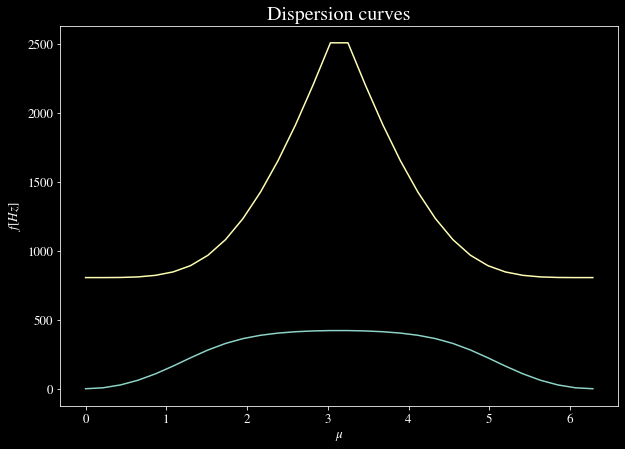

In [81]:
#X_=Kontrola.Visualise(mu, Mg, Kg, 4,type=1, xr=False)
w = Kontrola.Dispersion_curves(Mg, Kg, 0, 2*np.pi, n=2)

In [82]:
mu = np.linspace(0, np.pi, 4)
show = False

if show:
    for mui in mu:
        Kontrola.Animate(mui, Mg, Kg, N = 10, t=5, frames = 30, save=f"Metamaterial_mu_{mui:.3f}")

Preračuni vmzeti


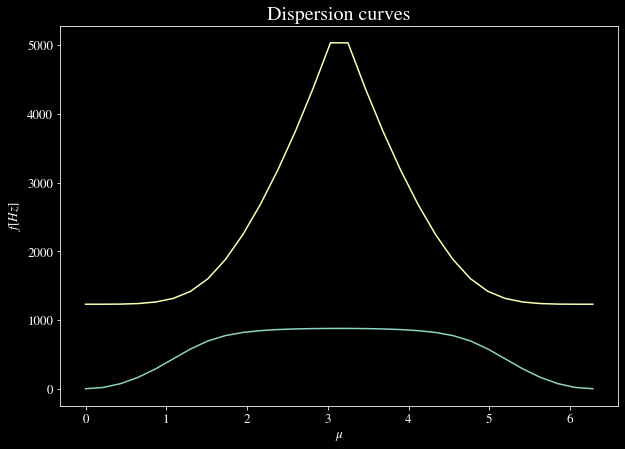

In [128]:
# Vzmet r5, w2.5, t0.7, a2

#Nosilec
h = 5e-3
b = 5e-3
I = (b*h**3)/12


#Solidworks + ansys
mr = 0.73e-3#
k = 23365.031

vzmet1 = BaseCell(E=2.89e9, I=I, A=b*h, L=25e-3, rho = 1339, n=31, k=k, sL =10e-3, m=mr)
Mg = vzmet1.Generate_Mg()
Kg = vzmet1.Generate_Kg()
w = vzmet1.Dispersion_curves(Mg, Kg, 0, 2*np.pi, n=2)

#Resonator do 400 Hz niha v druge smeri

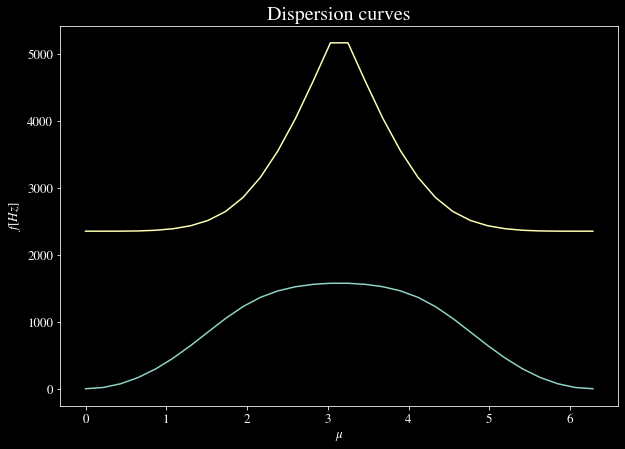

In [129]:
# Vzmet r5, w2.5, t0.5, a2

#Nosilec
h = 5e-3
b = 5e-3
I = (b*h**3)/12


#Solidworks + ansys
mr = 0.73e-3#
k = 86125.22

vzmet1 = BaseCell(E=2.89e9, I=I, A=b*h, L=25e-3, rho = 1339, n=31, k=k, sL =10e-3, m=mr)
Mg = vzmet1.Generate_Mg()
Kg = vzmet1.Generate_Kg()
w = vzmet1.Dispersion_curves(Mg, Kg, 0, 2*np.pi, n=2)